In [ ]:
import numpy as np
import pydot
import math
import pydrake
from IPython.display import SVG, display
from pydrake.math import RotationMatrix
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    StateInterpolatorWithDiscreteDerivative,
    Box,
    CoulombFriction,
    RigidTransform,
    Isometry3,
    PrismaticJoint,
)
from pydrake.systems.framework import BasicVector

import numpy as np
from pydrake.all import (
    ConstantVectorSource,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    MultibodyPositionToGeometryPose,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
    SpatialInertia,
    UnitInertia
)

from pydrake.multibody import inverse_kinematics
from pydrake.multibody.tree import LinearSpringDamper
from pydrake.trajectories import PiecewisePolynomial

from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import AddMultibodyTriad, MakeManipulationStation, AddShape
from manipulation.utils import running_as_notebook


In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://daf5bbc1-0953-4c3b-8316-bd7f6d460024.deepnoteproject.com/7000/


In [ ]:
keyMapping ={"Q":"", "W":"", "E":"", "R":"", "T":"","Y":"",
    "A":"","S":"","D":"","F":"","G":"","H":"","J":"","K":"","L":"",
    "Z":"","X":"","C":"","V":"","B":"","N":"","M":""}
keyCenters ={"Q":"", "W":"", "E":"", "R":"", "T":"","Y":"",
    "A":"","S":"","D":"","F":"","G":"","H":"","J":"","K":"","L":"",
    "Z":"","X":"","C":"","V":"","B":"","N":"","M":""}
lst1 = "POIUYTREWQ"
lst2 = "LKJHGFDSA"
lst3 = "MNBVCXZ"
for i in range(len(lst1)):
    keyMapping[lst1[i]] = [0.9, -0.22+0.05*i, 0.3]
    keyCenters[lst1[i]] = [0.9, -0.22-0.05+0.05*i, 0.3]
for i in range(len(lst2)):
    keyMapping[lst2[i]] = [0.84, -0.20+0.05*i, 0.3]
    keyCenters[lst2[i]] = [0.84, -0.20-0.05+0.05*i, 0.3]
for i in range(len(lst3)):
    keyMapping[lst3[i]] = [0.78, -0.14+0.05*i, 0.3]
    keyCenters[lst3[i]] = [0.78, -0.14-0.05+0.05*i, 0.3]
keyMapping["spacebar"] = [0.72,0.1,0.3]
keyCenters["spacebar"] = keyMapping["spacebar"] = [0.72,0.05-0.05,0.3]
print(keyMapping)

{'Q': [0.9, 0.23, 0.3], 'W': [0.9, 0.18000000000000002, 0.3], 'E': [0.9, 0.13000000000000003, 0.3], 'R': [0.9, 0.08000000000000004, 0.3], 'T': [0.9, 0.03, 0.3], 'Y': [0.9, -0.01999999999999999, 0.3], 'A': [0.84, 0.2, 0.3], 'S': [0.84, 0.15000000000000002, 0.3], 'D': [0.84, 0.10000000000000003, 0.3], 'F': [0.84, 0.04999999999999999, 0.3], 'G': [0.84, 0.0, 0.3], 'H': [0.84, -0.04999999999999999, 0.3], 'J': [0.84, -0.1, 0.3], 'K': [0.84, -0.15000000000000002, 0.3], 'L': [0.84, -0.2, 0.3], 'Z': [0.78, 0.16000000000000003, 0.3], 'X': [0.78, 0.10999999999999999, 0.3], 'C': [0.78, 0.06, 0.3], 'V': [0.78, 0.010000000000000009, 0.3], 'B': [0.78, -0.04000000000000001, 0.3], 'N': [0.78, -0.09000000000000001, 0.3], 'M': [0.78, -0.14, 0.3], 'P': [0.9, -0.22, 0.3], 'O': [0.9, -0.16999999999999998, 0.3], 'I': [0.9, -0.12, 0.3], 'U': [0.9, -0.06999999999999998, 0.3], 'spacebar': [0.72, 0.0, 0.3]}


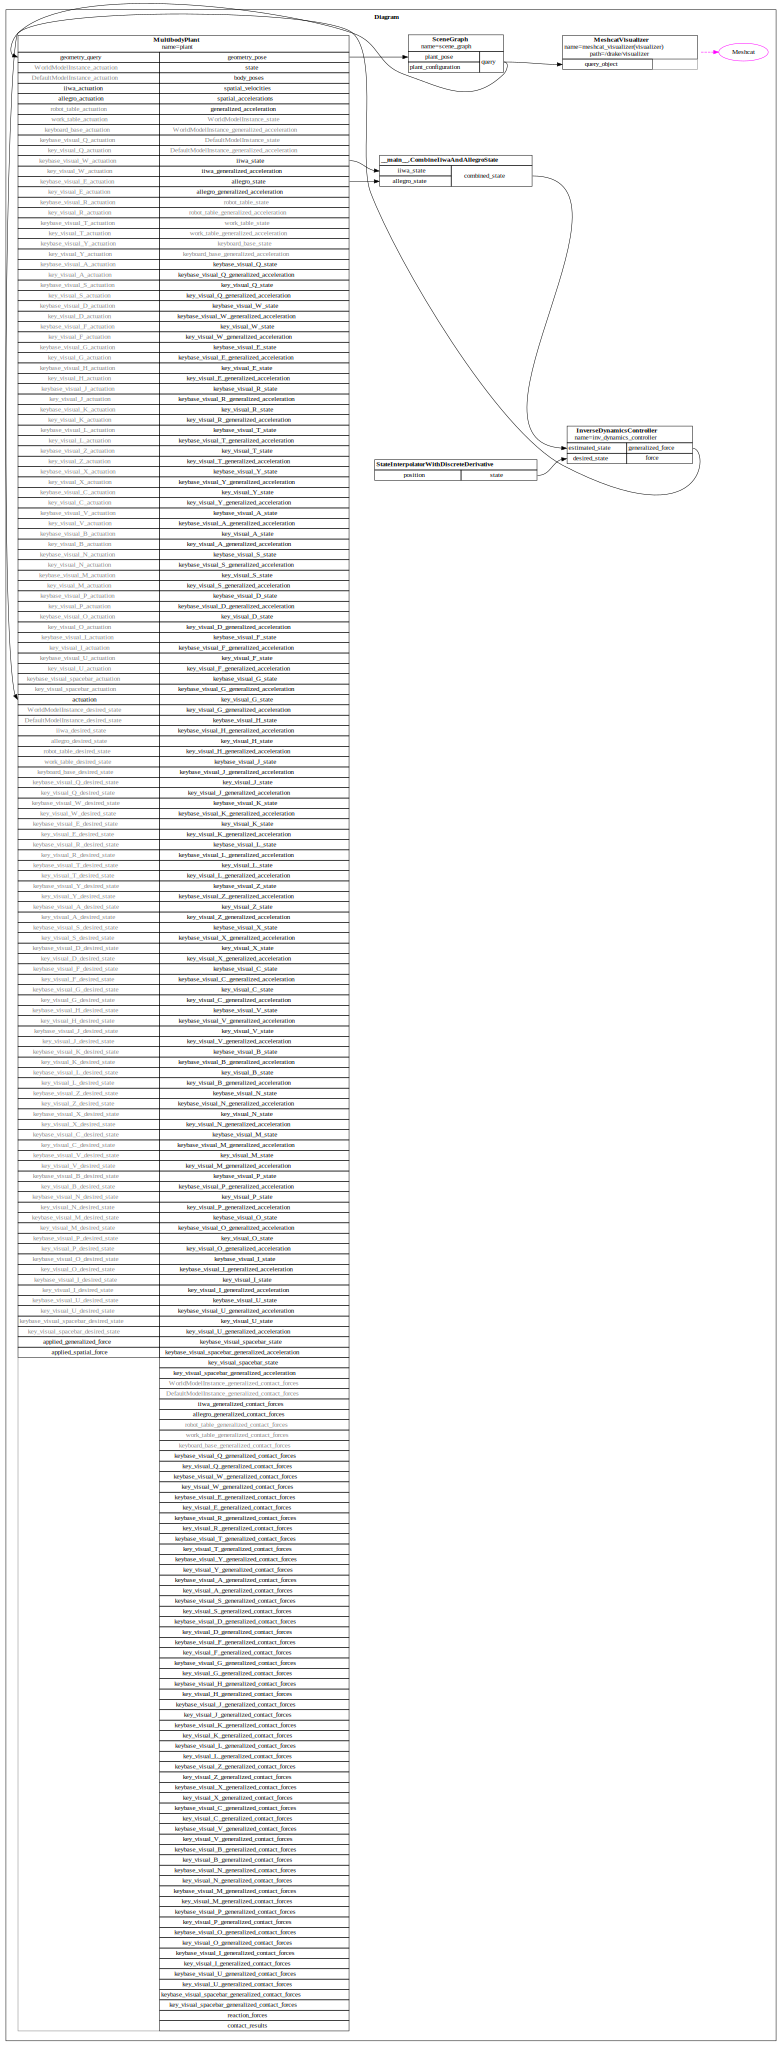

Q [0.9, 0.23, 0.3]
W [0.9, 0.18000000000000002, 0.3]
E [0.9, 0.13000000000000003, 0.3]
R [0.9, 0.08000000000000004, 0.3]
T [0.9, 0.03, 0.3]
Y [0.9, -0.01999999999999999, 0.3]
A [0.84, 0.2, 0.3]
S [0.84, 0.15000000000000002, 0.3]
D [0.84, 0.10000000000000003, 0.3]
F [0.84, 0.04999999999999999, 0.3]
G [0.84, 0.0, 0.3]
H [0.84, -0.04999999999999999, 0.3]
J [0.84, -0.1, 0.3]
K [0.84, -0.15000000000000002, 0.3]
L [0.84, -0.2, 0.3]
Z [0.78, 0.16000000000000003, 0.3]
X [0.78, 0.10999999999999999, 0.3]
C [0.78, 0.06, 0.3]
V [0.78, 0.010000000000000009, 0.3]
B [0.78, -0.04000000000000001, 0.3]
N [0.78, -0.09000000000000001, 0.3]
M [0.78, -0.14, 0.3]
P [0.9, -0.22, 0.3]
O [0.9, -0.16999999999999998, 0.3]
I [0.9, -0.12, 0.3]
U [0.9, -0.06999999999999998, 0.3]
spacebar [0.72, 0.0, 0.3]


In [ ]:
robot_directives = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-0.1]
        iiwa_joint_2: [0.5]
        iiwa_joint_3: [0.0]
        iiwa_joint_4: [-0.8]
        iiwa_joint_5: [0.0]
        iiwa_joint_6: [0]
        iiwa_joint_7: [0.1]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: allegro
    file: package://drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: allegro::hand_root
    X_PC:
        translation: [0, 0, 0.05]
        rotation: !Rpy { deg: [0, 0, 0]}
"""

environment_directives = """
directives:
- add_model:
    name: robot_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: robot_table::link
    X_PC:
        translation: [0, 0, -0.792]
- add_model:
    name: work_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
    
- add_weld:
    parent: world
    child: work_table::link
    X_PC:
        translation: [0.75, 0, -0.792]
"""

           

builder = DiagramBuilder()

time_step = 0.01
# Build one plant to model the world
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step)
parser = Parser(plant)
parser.AddModelsFromString(robot_directives, ".dmd.yaml")
## Add any other models you want the robot to manipulate here.
parser.AddModelsFromString(environment_directives, ".dmd.yaml")

color_base = [0.3,0.2,0.1,1]           

box1_name = "box1"
box1_size = [0.04, 0.04, 0.04]

box2_name = "box2"
box2_size = [0.04, 0.04, 0.04]

mu = 0.5
mass = 0.1
initial_pose = RigidTransform([0.3, 0.5, 0.7])
base_size = [.3,1.5,0.2]
keyboard_base = AddShape(plant, pydrake.geometry.Box(base_size[0],base_size[1],base_size[2]), name="keyboard_base", mass=10, mu=mu, color=color_base)



plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("keyboard_base"), RigidTransform(p=[0.8, 0, 0.1]))

space_bar_size = [0.04,0.20,0.04]
color_white = [1,1,1,1]

def newKeyHinge(keyName,keyNames,boxSize = box1_size):
    
    keybase_visual = AddShape(plant, pydrake.geometry.Box(boxSize[0],boxSize[1],boxSize[2]), 
    name="keybase_visual_"+keyName, mass=mass, mu=mu, color=color_base)
    

    key_top_visual = AddShape(plant, pydrake.geometry.Box(boxSize[0],boxSize[1],boxSize[2]), 
    name="key_visual_"+keyName, mass=mass, mu=mu, color=color_white)

    keyNames[keyName] = "keybase_visual_"+keyName
    key_Joint = plant.AddJoint(
                            PrismaticJoint(name = "key_joint_name"+keyName,
                            frame_on_parent=plant.GetFrameByName("keybase_visual_"+keyName),
                            frame_on_child=plant.GetFrameByName("key_visual_"+keyName),
                            axis=[0,0,1],
                            pos_upper_limit = 1,
                            pos_lower_limit = 0.01,
                            damping=0))

    key_Joint.set_default_translation(1.01742463e-01)

    key_spring = plant.AddForceElement(
                LinearSpringDamper( bodyA = plant.GetBodyByName("keybase_visual_"+keyName),
                                    p_AP = [0,0,boxSize[2]*0.1*0.5],
                                    bodyB = plant.GetBodyByName("key_visual_"+keyName),
                                    p_BQ = [0,0,-boxSize[2]*0.5],
                                    free_length = 0.2,
                                    stiffness = 10,
                                    damping = 1.2)            )  
    

keyFrameNames  = {}
for key in keyMapping.keys():
    if key!= "spacebar":
        newKeyHinge(key,keyFrameNames)
#space bar
newKeyHinge("spacebar",keyFrameNames, boxSize = space_bar_size)
plant.Finalize()

def detectPressed(key, past_deflection = None):
    position_body_A = plant.EvalBodyPoseInWorld(plant.GetMyContextFromRoot(context),plant.GetBodyByName("keybase_visual_" + key)).translation()
    position_body_B = plant.EvalBodyPoseInWorld(plant.GetMyContextFromRoot(context),plant.GetBodyByName("key_visual_" + key)).translation()

    # Calculate deflection by subtracting initial positions from current positions
    deflection = position_body_B - position_body_A
    pressed = False
    if(past_deflection is not None):
        #diff = deflection- past_deflection
        diff = past_deflection - deflection
        if((diff[2]) >= 0.01):
            pressed = True
    return pressed, deflection



# Build a second plant for the controller to use, which will ONLY have the iiwa
# and wsg. This one is *not* added to builder directly.
controller_plant = MultibodyPlant(time_step)
Parser(controller_plant).AddModelsFromString(robot_directives, ".dmd.yaml")
controller_plant.Finalize()
num_positions = controller_plant.num_positions()

# Add an inverse dynamics controller which uses the controller_plant.
inv_dynamics_controller = builder.AddSystem(
    InverseDynamicsController(
        controller_plant,
        kp=[100] * num_positions,
        ki=[1] * num_positions,
        kd=[20] * num_positions,
        has_reference_acceleration=False,
    )
)
inv_dynamics_controller.set_name("inv_dynamics_controller")
builder.Connect(
    inv_dynamics_controller.get_output_port_control(),
    plant.get_actuation_input_port(),
)
# Because we want this controller to use the estimated state of both the iiwa and the allegro (which are in two separate model instances), we need to mux those together.
iiwa = plant.GetModelInstanceByName("iiwa")
allegro = plant.GetModelInstanceByName("allegro")



class CombineIiwaAndAllegroState(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort(
            "iiwa_state", plant.num_multibody_states(iiwa)
        )
        self.DeclareVectorInputPort(
            "allegro_state", plant.num_multibody_states(allegro)
        )
        self.DeclareVectorOutputPort(
            "combined_state",
            plant.num_multibody_states(iiwa)
            + plant.num_multibody_states(allegro),
            self.CalcOutput,
        )

    def CalcOutput(self, context, output):
        iiwa_state = self.get_input_port(0).Eval(context)
        allegro_state = self.get_input_port(1).Eval(context)
        #print(iiwa_state)
        #print(allegro_state)
        # The order should should be [q_iiwa, q_allegro, v_iiwa, v_allegro]
        output.SetFromVector(
            np.concatenate(
                (
                    iiwa_state[: plant.num_positions(iiwa)],
                    allegro_state[: plant.num_positions(allegro)],
                    iiwa_state[plant.num_positions(iiwa) :],
                    allegro_state[plant.num_positions(allegro) :],
                )
            )
        )


combined_state = builder.AddSystem(CombineIiwaAndAllegroState())
builder.Connect(
    plant.get_state_output_port(iiwa), combined_state.get_input_port(0)
)
builder.Connect(
    plant.get_state_output_port(allegro), combined_state.get_input_port(1)
)
builder.Connect(
    combined_state.get_output_port(),
    inv_dynamics_controller.get_input_port_estimated_state(),
)

# Optional: If you want to only send positions, not also velocities (like the iiwa), then you can add this system:
desired_state_from_position = builder.AddSystem(
    StateInterpolatorWithDiscreteDerivative(
        controller_plant.num_positions(),
        time_step,
        suppress_initial_transient=True,
    )
)
builder.Connect(
    desired_state_from_position.get_output_port(),
    inv_dynamics_controller.get_input_port_desired_state(),
)

visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()

display(
    SVG(
        pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

simulator = Simulator(diagram)
visualizer.StartRecording(True)
context = simulator.get_mutable_context()



for key,pos in keyMapping.items():
    print(key, pos)
    name = keyFrameNames[key]
    initial_pose_key = RigidTransform(
                    R=RotationMatrix([
                        [0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0],
                    ]),
                    p=pos,
                    )
    plant.SetFreeBodyPose(plant.GetMyContextFromRoot(context), plant.GetBodyByName(name), initial_pose_key)



In [ ]:
pi = math.pi


#RigidTransform(RotationMatrix.MakeYRotation(pi),np.array([0.63, 0.12+y_adjustment, 0.2+z_adjustment]))]

def create_q_knots(pose_lst, finger_choice):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    world_frame = controller_plant.world_frame()
    #gripper_frame = controller_plant.GetFrameByName(finger_choice)

    """press_button_positions = [0]*23
    #press_button_positions[:7] = [0.1, 0.5, 0.0, -0.8, 0.0, 1.6, 0.1]  # pre pressing positions
    press_button_positions[:7] = [-0.1, 0.5, 0.0, -1.2, 0.0, 0, 0.1]
    #press_button_positions[11:] = [1.0]*12
    press_button_positions[7:] = [0]*16
    #press_button_positions[8] = 2.0

    q_nominal = np.array(press_button_positions)  """
    # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )
    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )
    press_button_positions3 = [0]*23
    press_button_positions3[:7] = [-0.1, 0.5, 0.0, -1.2, 0.0, 0, 0.1]
    press_button_positions3[7:] = [0]*16
    press_button_positions3[8] = 2.0

    press_button_positions7 = [0]*23
    press_button_positions7[:7] = [-0.1, 0.5, 0.0, -1.2, 0.0, 0, 0.1]
    press_button_positions7[7:] = [0]*16
    press_button_positions7[12] = 2.0

    press_button_positions11 = [0]*23
    press_button_positions11[:7] = [-0.1, 0.5, 0.0, -1.2, 0.0, 0, 0.1]
    press_button_positions11[7:] = [0]*16
    press_button_positions11[6] = 2.0

    press_button_positions15 = [0]*23
    press_button_positions15[:7] = [-0.1, 0.5, 0.0, -1.2, 0.0, 0, 0.1]
    press_button_positions15[7:] = [0]*16
    press_button_positions15[11] = 1

    starting_pos_dict = {"link_3":press_button_positions3,"link_7":press_button_positions7, "link_11":press_button_positions11, "link_15":press_button_positions15}
    for i in range(len(pose_lst)):

        q_nominal = np.array(starting_pos_dict[finger_choice[i]])  
        gripper_frame = controller_plant.GetFrameByName(finger_choice[i])
        ik = inverse_kinematics.InverseKinematics(controller_plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #print("qvariables", q_variables)
        #print("nominal", q_nominal)

        #### Modify here ###############################

        ################################################
        # Add orientation constraint
        R_WG = pose_lst[i].rotation()
        orientation_bounds = 0.1  # Set your desired orientation constraint bounds here
        AddOrientationConstraint(ik, R_WG, orientation_bounds)

        # Add position constraint
        p_WG_lower = pose_lst[i].translation() #- np.array([0.05, 0.05, 0.05])  # Set lower position bounds
        p_WG_upper = pose_lst[i].translation() #+ np.array([0.05, 0.05, 0.05])  # Set upper position bounds
        AddPositionConstraint(ik, p_WG_lower, p_WG_upper)

        # Add joint-centering cost
        joint_centering_weight = 1.0  # Set your desired joint centering cost weight here
        joint_centering_cost = np.sum((q_variables - q_nominal) ** 2)
        prog.AddCost(joint_centering_cost)

        # Set initial guess
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[-1])

        result = Solve(prog)

        assert result.is_success()

        q_knots.append(result.GetSolution(q_variables))

    return q_knots

In [ ]:
finger_map = {}
alphabet = "QWERTYUIOPASDFGHJKLZXCVBNM "
for i in range(len(alphabet)):
    key = alphabet[i]
    if key in {"Q","W","E", "A", "S", "D", "Z","X","C"}:
        #index
        finger_map[key] = "link_3"
    elif key in {"R","T","Y","U","F","G","H","V","B","N"}:
        #middle
        finger_map[key] = "link_7"
        pass
    else:
        #pinky
        finger_map[key] = "link_11"
        pass
finger_map["spacebar"] = "link_3" #index
print(finger_map)


{'Q': 'link_3', 'W': 'link_3', 'E': 'link_3', 'R': 'link_7', 'T': 'link_7', 'Y': 'link_7', 'U': 'link_7', 'I': 'link_11', 'O': 'link_11', 'P': 'link_11', 'A': 'link_3', 'S': 'link_3', 'D': 'link_3', 'F': 'link_7', 'G': 'link_7', 'H': 'link_7', 'J': 'link_11', 'K': 'link_11', 'L': 'link_11', 'Z': 'link_3', 'X': 'link_3', 'C': 'link_3', 'V': 'link_7', 'B': 'link_7', 'N': 'link_7', 'M': 'link_11', ' ': 'link_11', 'spacebar': 'link_3'}


In [ ]:
pose_lst = []
finger_lst = []
message = "THANKS"

for i in range(len(message)):
    letter = message[i]
    if(letter == " "):
        letter = "spacebar"
    y_offset = 0.04
    x_offset = 0
    z_press_adjustment = 0.1
    z_pre_adjustment = 0.3
    pose_lst.append(RigidTransform(RotationMatrix.MakeYRotation(pi), np.array(keyCenters[letter])+ np.array([x_offset,y_offset,z_pre_adjustment])))
    pose_lst.append(RigidTransform(RotationMatrix.MakeYRotation(pi), np.array(keyCenters[letter])+ np.array([x_offset,y_offset,z_press_adjustment])))
    finger_lst.append(finger_map[letter])
    finger_lst.append(finger_map[letter])
#pose_lst = [RigidTransform(RotationMatrix.MakeYRotation(pi), np.array(keyCenters[letter])+ np.array([x_offset,0,z_pre_adjustment])),
#RigidTransform(RotationMatrix.MakeYRotation(pi), np.array(keyCenters[letter])+ np.array([x_offset,0,z_press_adjustment]))]
q_knots = list(np.array(create_q_knots(pose_lst,finger_lst)))
desired_positions_list = [q_knots[0],q_knots[0],q_knots[0],q_knots[0],q_knots[0],q_knots[0],q_knots[0]]
print(len(q_knots))
print(len(message))
for i in range(len(message)):
    desired_positions_list.append(q_knots[2*i])
    desired_positions_list.append(q_knots[2*i])
    desired_positions_list.append(q_knots[2*i+1])
    desired_positions_list.append(q_knots[2*i])

12
6


In [ ]:
#message = ""
simulator.set_target_realtime_rate(1)

current_time = 0
#z_pressed, z_deflection = detectPressed("Z")
#x_pressed, x_deflection = detectPressed("X")
pressed_dict = {}
press_button_positions15 = [0]*23
press_button_positions15[:7] = [-0.1, 0.5, 0.0, -1.2, 0.0, 0, 0.1]
press_button_positions15[7:] = [0]*16
press_button_positions15[11] = 1
#desired_positions_list = [press_button_positions15]
for j in range(len(alphabet)):
        l = alphabet[j]
        if alphabet[j] == " ":
            l = "spacebar"
        pressed_key, deflection_key = detectPressed(l)
        pressed_dict[l] = deflection_key
for i,desired_position in enumerate(desired_positions_list):
    #key_Joint.set_translation(plant.GetMyContextFromRoot(context),0.2)
    # Set the desired joint positions
    desired_state_from_position.get_input_port().FixValue(
        desired_state_from_position.GetMyMutableContextFromRoot(context),
        desired_position
    )
    #z_pressed,z_deflection = detectPressed("Z",z_deflection)
    #x_pressed, x_deflection = detectPressed("X",x_deflection)

    for j in range(len(alphabet)):
        l = alphabet[j]
        if l == " ":
            l = "spacebar"
        pressed_key, deflection_key = detectPressed(l,pressed_dict[l])
        pressed_dict[l] = deflection_key
        if(pressed_key):
            print(l, " pressed!")

    current_time += 0.3
    simulator.AdvanceTo(current_time)
visualizer.PublishRecording()

T  pressed!
H  pressed!
A  pressed!
N  pressed!
K  pressed!
S  pressed!


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=daf5bbc1-0953-4c3b-8316-bd7f6d460024' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>